# Desafio 1: Properti

## Objetivos:
-  Efectuar una limpieza del dataset provisto. Particularmente, deberá diseñar estrategias para lidiar con los datos perdidos en ciertas variables.

-  Realizar un análisis descriptivo de las principales variables.

- Crear nuevas columnas a partir de las características dadas que puedan tener valor predictivo.

## Preparacion de ambiente
### Importar Librerias
**Numpy** y **Pandas** son importadas para administrar todas las operaciones analiticas 

**IPython** es utilizados para administrar la visualizacion de los datos

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display

### Importar archivo CSV
Utilizando Pandas importamos el archivo CSV considerando la comma como delimitador 

In [2]:
dfprop=pd.read_csv(filepath_or_buffer='properatti.csv',delimiter=',',index_col = 0 )

## Visualizacion
### Visualizar la forma del Dataframe
Se utilizara la funcion nativa **shape** de la clase DataFrame para visualizar:
- Cantidad de observaciones 
- Cantidad de variables

In [3]:
dfprop.shape

(121220, 25)

### Visualizar estructura del Dataframe
Se utilizara la funcion nativa **info()** de la clase DataFrame para visualizar:
- Cantidad de variables
- Nombre de variables
- Cantidad de registros con valores **No nulos**
- Tipo de dato

In [4]:
dfprop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121220 entries, 0 to 121219
Data columns (total 25 columns):
operation                     121220 non-null object
property_type                 121220 non-null object
place_name                    121197 non-null object
place_with_parent_names       121220 non-null object
country_name                  121220 non-null object
state_name                    121220 non-null object
geonames_id                   102503 non-null float64
lat-lon                       69670 non-null object
lat                           69670 non-null float64
lon                           69670 non-null float64
price                         100810 non-null float64
currency                      100809 non-null object
price_aprox_local_currency    100810 non-null float64
price_aprox_usd               100810 non-null float64
surface_total_in_m2           81892 non-null float64
surface_covered_in_m2         101313 non-null float64
price_usd_per_m2              68617 n

## Visualizacion de valores Nan en cada variable

Visualizamos la cantidad de valores Nan para cada variable  

In [5]:
dfprop[dfprop.isnull().any(axis=1)].isna().sum()

operation                          0
property_type                      0
place_name                        23
place_with_parent_names            0
country_name                       0
state_name                         0
geonames_id                    18717
lat-lon                        51550
lat                            51550
lon                            51550
price                          20410
currency                       20411
price_aprox_local_currency     20410
price_aprox_usd                20410
surface_total_in_m2            39328
surface_covered_in_m2          19907
price_usd_per_m2               52603
price_per_m2                   33562
floor                         113321
rooms                          73830
expenses                      106958
properati_url                      0
description                        2
title                              0
image_thumbnail                 3112
dtype: int64

## Limpieza de datos
### Eliminacion de inmuebles sin valor analitico

Eliminamos los inmuebles sin precio ni ubicaciones, ya que no tenemos ninguna forma de estimar un precio.

Condicion:
- price == Nan
- price_aprox_local_currency == Nan
- price_aprox_usd == Nan
- surface_total_in_m2 == Nan
- surface_covered_in_m2 == Nan


Los registros eliminados son 4733 

In [6]:
# Generamos una mascara para encontrar todos los registros bajo esta condicion
dfprop_withoutprice_withoutsurface=((dfprop['price'].isna()==True)\
                                    &(dfprop['price_aprox_local_currency'].isna()==True)\
                                    &(dfprop['price_aprox_usd'].isna()==True)\
                                    &(dfprop['surface_total_in_m2'].isna()==True)\
                                    &(dfprop['surface_covered_in_m2'].isna()==True))

# Instanciamos el Dataframe excluyendo los registros que no cumple con dicha condicion
dfprop=dfprop.loc[~dfprop_withoutprice_withoutsurface]


Visualizamos la forma para confirmar que se hayan eliminado los registros

In [7]:
dfprop.shape

(116487, 25)

### Separar en un nuevo Dataframe los inmuebles cuya concentracion por provincia sea menor a 30 operaciones 

Dejaremos en un nuevo DataFrame denominado 'dfprop_fewlocations' las propiedades cuya agrupacion por provincia sea menor a 30 por no tener un valor referencial para la estimacion de precios

In [8]:
#Creamos dataframe con un valor booleano que indica si la provincia tiene menos de 30 propiedades (True) o no (False).
dfprop_stateless30locations=dfprop.groupby('state_name')[['operation']].count()<30

# Renombramos la columna  
dfprop_stateless30locations.rename(columns={'state_name':'state_name','operation':'less_30_locations'},inplace=True)

# Hacemos un merge con dfprop para marcar cada una de las propiedades
dfprop=pd.merge(dfprop,dfprop_stateless30locations,how='left',on='state_name')
    
# Generamos un nuevo Dataframe para almacenar las propiedades correspondientes a provincias con menos de 30 propiedades
dfprop_fewlocations=dfprop.loc[dfprop['less_30_locations']==True]

# Eliminamos del dataframe proncipal dichas ubiaciones
dfprop=dfprop.loc[dfprop['less_30_locations']==False]

#Eliminamos las columnas de ambos dataframes
dfprop_fewlocations.drop(['less_30_locations'],axis=1,inplace=True)
dfprop.drop(['less_30_locations'],axis=1,inplace=True)

#Verificamos la cantidad de ubicaciones dentro del dataframe auxiliar
dfprop_fewlocations.shape

(74, 25)

In [9]:
#Corroboramos que se hayan eliminado las propiedades del dataframe principal
dfprop.shape

(116413, 25)

Eliminamos propiedad en moneda distinta a ARS o USD (se excluye 'NaN' siendo que tendran tratamiento mas adelante) 

In [10]:
dfprop['currency'].unique()


array(['USD', nan, 'ARS', 'PEN', 'UYU'], dtype=object)

In [11]:
dfprop=dfprop.loc[((dfprop['currency']!='UYU')&(dfprop['currency']!='PEN'))]

#Corroboramos que se hayan eliminado las propiedades del dataframe principal
dfprop['currency'].unique()

array(['USD', nan, 'ARS'], dtype=object)

Eliminamos la categoria 'store', siendo que nuestro analisis será para viviendas de ocupacion permanente.

In [12]:
dfprop['property_type'].unique()

array(['PH', 'apartment', 'house', 'store'], dtype=object)

In [13]:
dfprop=dfprop.loc[(dfprop['property_type']!='store')]

In [14]:
dfprop['property_type'].unique()

array(['PH', 'apartment', 'house'], dtype=object)

# Imputacion
## Variable place_name - valores Nan:  
- Analizamos los valores NaN de la columna 'place_name':

In [15]:
dfprop.loc[(dfprop['place_name'].isna() == True),['place_name','place_with_parent_names']]

,place_name,place_with_parent_names
6201,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
9686,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
10855,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
14066,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
17672,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
20765,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
22398,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
23404,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
36842,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
43577,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||


- Vemos que, de acuerdo a 'place_name_with_parents', todos los valores faltantes son 'Tigre'.
- Por lo tanto, procedemos a reemplazarlos:

In [16]:
dfprop['place_name'].fillna( value = 'Tigre', inplace = True)

Volvemos a visualizar la cantidad de valores nulos para confirmar que no haya mas valores **Nan** en la variable 'place_name'

In [17]:
dfprop[dfprop.isnull().any(axis=1)].isna().sum()

operation                          0
property_type                      0
place_name                         0
place_with_parent_names            0
country_name                       0
state_name                         0
geonames_id                    17992
lat-lon                        48544
lat                            48544
lon                            48544
price                          14973
currency                       14974
price_aprox_local_currency     14973
price_aprox_usd                14973
surface_total_in_m2            33301
surface_covered_in_m2          14356
price_usd_per_m2               45984
price_per_m2                   27407
floor                         104901
rooms                          67543
expenses                       98647
properati_url                      0
description                        2
title                              0
image_thumbnail                 2666
dtype: int64

## Variables 'surface_total_in_m2' y 'surface_covered_in_m2' - valores Nan
Analizamos los valores que tienen 'surface_covered_in_m2', pero no 'surface_total_in_m2'

In [18]:
dfprop.isnull().sum()

operation                          0
property_type                      0
place_name                         0
place_with_parent_names            0
country_name                       0
state_name                         0
geonames_id                    17992
lat-lon                        48544
lat                            48544
lon                            48544
price                          14973
currency                       14974
price_aprox_local_currency     14973
price_aprox_usd                14973
surface_total_in_m2            33301
surface_covered_in_m2          14356
price_usd_per_m2               45984
price_per_m2                   27407
floor                         104901
rooms                          67543
expenses                       98647
properati_url                      0
description                        2
title                              0
image_thumbnail                 2666
dtype: int64

In [19]:
dfprop_surfaceanalysis = dfprop[(dfprop['surface_total_in_m2'].isna() == True) & (dfprop['surface_covered_in_m2'].isna() == False)]
dfprop_surfaceanalysis[['surface_total_in_m2', 'surface_covered_in_m2']].sample(10)

,surface_total_in_m2,surface_covered_in_m2
115213,NaN,90.0
40950,NaN,40.0
8213,NaN,270.0
44225,NaN,60.0
65183,NaN,270.0
14126,NaN,175.0
7410,NaN,107.0
5724,NaN,52.0
75911,NaN,120.0
46882,NaN,65.0


Reemplazamos los valores NaN de la columna 'surface_total_in_m2', asumiendo que en estos casos es igual al valor de 'surface_covered_in_m2'

In [20]:
dfprop.fillna({'surface_total_in_m2' : dfprop['surface_covered_in_m2']}, inplace = True)

Volvemos a constatar la cantidad de valores nulos en el dataframe:

In [21]:
dfprop.isnull().sum()

operation                          0
property_type                      0
place_name                         0
place_with_parent_names            0
country_name                       0
state_name                         0
geonames_id                    17992
lat-lon                        48544
lat                            48544
lon                            48544
price                          14973
currency                       14974
price_aprox_local_currency     14973
price_aprox_usd                14973
surface_total_in_m2             7283
surface_covered_in_m2          14356
price_usd_per_m2               45984
price_per_m2                   27407
floor                         104901
rooms                          67543
expenses                       98647
properati_url                      0
description                        2
title                              0
image_thumbnail                 2666
dtype: int64

Repetimos la operación para los casos en los que no tenemos valor de 'surface_covered_in_m2', completando con el valor de 'surface_total_in_m2':

In [22]:
dfprop_surfaceanalysis = dfprop[(dfprop['surface_covered_in_m2'].isna() == True) & (dfprop['surface_total_in_m2'].isna() == False)]
dfprop_surfaceanalysis[['surface_total_in_m2', 'surface_covered_in_m2']].sample(10)

,surface_total_in_m2,surface_covered_in_m2
48749,70.0,NaN
66409,37.0,NaN
74169,55.0,NaN
27202,240.0,NaN
100393,48.0,NaN
32014,900.0,NaN
105741,40.0,NaN
66897,221.0,NaN
100184,350.0,NaN
8200,65.0,NaN


In [23]:
dfprop.fillna({'surface_covered_in_m2' : dfprop['surface_total_in_m2']}, inplace = True)


In [24]:
dfprop.isnull().sum()

operation                          0
property_type                      0
place_name                         0
place_with_parent_names            0
country_name                       0
state_name                         0
geonames_id                    17992
lat-lon                        48544
lat                            48544
lon                            48544
price                          14973
currency                       14974
price_aprox_local_currency     14973
price_aprox_usd                14973
surface_total_in_m2             7283
surface_covered_in_m2           7283
price_usd_per_m2               45984
price_per_m2                   27407
floor                         104901
rooms                          67543
expenses                       98647
properati_url                      0
description                        2
title                              0
image_thumbnail                 2666
dtype: int64

Imputamos la variable 'price_per_m2' calculandola en base a 'price_aprox_us' y 'surface_total_in_m2' 

In [25]:

dfprop.loc[dfprop['price_usd_per_m2'].isna() &\
           (~dfprop['price_aprox_usd'].isna())&\
            (~dfprop['surface_total_in_m2'].isna())&\
            (dfprop['surface_total_in_m2']!=0.),\
           'price_usd_per_m2']= dfprop['price_aprox_usd']/dfprop['surface_total_in_m2']

In [26]:
dfprop.isnull().sum()

operation                          0
property_type                      0
place_name                         0
place_with_parent_names            0
country_name                       0
state_name                         0
geonames_id                    17992
lat-lon                        48544
lat                            48544
lon                            48544
price                          14973
currency                       14974
price_aprox_local_currency     14973
price_aprox_usd                14973
surface_total_in_m2             7283
surface_covered_in_m2           7283
price_usd_per_m2               22497
price_per_m2                   27407
floor                         104901
rooms                          67543
expenses                       98647
properati_url                      0
description                        2
title                              0
image_thumbnail                 2666
dtype: int64

In [27]:
dfprop.shape

(112458, 25)

Eliminamos propiedades sin precio y con cantidad de metro=0

In [28]:

dfprop=dfprop.drop(dfprop.loc[(dfprop['price_usd_per_m2'].isna())&
                                 (dfprop['price'].isna())&
                                 (dfprop['surface_total_in_m2']==0)].index)

dfprop.shape

(112327, 25)

### Variable  'state_name' vs 'place_with_parent_names'
Notamos que la columna **'place_name'** contiene valores no que aportan una clara referencia de la ubicacion geografica del inmueble.

Por ejemplo
- place_name: 'Centro'
- place_with_parent_names: '|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|Centro|'

Adicionalmente, los valores contenidos por esta columna no tienen el mismo valor referencial, lo cual difculta entender la precision de dicha columna. 

Por ello utilizamos **'place_with_parent_names'** que nos permite definir correctamente la ubicacion geografica del inmueble. 

Por lo tanto, separamos el texto y generaremos una nueva columna quedando el dataset con esta estructura.

- country_name: Pais
- state_name: provincia (salvo buenos aires que indicara la zona)
- district_name: localidad o partido
- city_name: barrio


In [29]:
# Split por el caracter "|"
dfplacename=[sublista.split('|') for sublista in dfprop['place_with_parent_names']]

# De cada una de las listas quitamos el ultimo y el primer caracter, ya que son vacios
# ['', 'Argentina', 'Bs.As. G.B.A. Zona Norte', 'Vicente López', 'Munro', '']
dfplacename=[sublista[1:5] for sublista in dfplacename]


# Se extrae el nombre de distrito o localidad en una nueva variable denominada 'district_name'
dfprop['district_name']=[str.strip(sublista[2]) if str.strip(sublista[2])!='' else np.nan for sublista in dfplacename]


# Se extrae el nombre de la ciudad o barrio en una nueva variable denominada 'city_name'
dfprop['city_name']=[str.strip(sublista[3]) if (len(sublista)>3  and sublista[3]) else np.nan for sublista in dfplacename]

# Finalmente columnas a ser utilizada seran:
# 'country_name'
# 'state_name'
# 'district_name'
#  'city_name'
# A partir de esas hacer las imputaciones

dfprop[['country_name','state_name','district_name','city_name']].sample(10)

,country_name,state_name,district_name,city_name
93123,Argentina,Santa Fe,Rosario,NaN
82141,Argentina,Capital Federal,San Telmo,NaN
66309,Argentina,Bs.As. G.B.A. Zona Sur,Lanús,Remedios de Escalada
10273,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,Nordelta
99242,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,Nordelta
76244,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,Nordelta
95276,Argentina,Bs.As. G.B.A. Zona Oeste,Tres de Febrero,Ciudadela
72461,Argentina,Bs.As. G.B.A. Zona Norte,San Isidro,Martínez
101319,Argentina,Santa Fe,Rosario,NaN
95519,Argentina,Capital Federal,Chacarita,NaN


### Eliminamos inmuebles sin nombre del distrito

Quitamos casos sin district_name ya que no nos permiten brindar un valor de referencia debido a que no tienen una zona claramente indicada   

In [30]:
mask_nodistrict_nocity_silatlon=(dfprop['district_name'].isna()==True)
dfprop=dfprop.loc[~mask_nodistrict_nocity_silatlon]
dfprop.shape

(108003, 27)

### Eliminamos las propiedades que por 'district_name' no lleguen a 30 operaciones

In [31]:
dfprop.groupby(by=['district_name']).count()

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,city_name
district_name,,,,,,,,,,,,,,,,,,,,,
Abasto,103,103,103,103,103,103,0,68,68,68,...,92,88,17,61,26,103,103,103,97,0
Achiras,7,7,7,7,7,7,7,7,7,7,...,1,1,1,7,0,7,7,7,7,0
Adolfo Alsina,8,8,8,8,8,8,8,3,3,3,...,0,0,0,8,0,8,8,8,8,0
Agronomía,39,39,39,39,39,39,39,39,39,39,...,36,35,2,32,8,39,39,39,39,0
Agua de Oro,6,6,6,6,6,6,6,2,2,2,...,3,3,0,1,0,6,6,6,6,0
Aguas Verdes,15,15,15,15,15,15,15,15,15,15,...,6,6,1,14,0,15,15,15,15,0
Aldea Brasilera,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,0,1,1,1,1,0
Alejandro Roca,1,1,1,1,1,1,0,0,0,0,...,1,1,0,1,0,1,1,1,0,0
Almafuerte,7,7,7,7,7,7,7,3,3,3,...,1,1,0,5,0,7,7,7,7,0


In [32]:
#Creamos dataframe con un valor booleano que indica si district tiene menos de 30 propiedades (True) o no (False).
dfprop_districtless30locations=dfprop.groupby('district_name')[['operation']].count()<30

# Renombramos la columna  
dfprop_districtless30locations.rename(columns={'district_name':'district_name','operation':'less_30_locations'},inplace=True)

# Hacemos un merge con dfprop para marcar cada una de las propiedades
dfprop=pd.merge(dfprop,dfprop_districtless30locations,how='left',on='district_name')
    
# Generamos un nuevo Dataframe para almacenar las propiedades correspondientes a district con menos de 30 propiedades
dfprop_fewlocations=dfprop.loc[dfprop['less_30_locations']==True]

# Eliminamos del dataframe proncipal dichas ubiaciones
dfprop=dfprop.loc[dfprop['less_30_locations']==False]

#Eliminamos las columnas de ambos dataframes
dfprop_fewlocations.drop(['less_30_locations'],axis=1,inplace=True)
dfprop.drop(['less_30_locations'],axis=1,inplace=True)

#Verificamos la cantidad de ubicaciones dentro del dataframe auxiliar
dfprop_fewlocations.shape

(1895, 27)

In [33]:
dfprop.groupby(by=['district_name']).count()

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,city_name
district_name,,,,,,,,,,,,,,,,,,,,,
Abasto,103,103,103,103,103,103,0,68,68,68,...,92,88,17,61,26,103,103,103,97,0
Agronomía,39,39,39,39,39,39,39,39,39,39,...,36,35,2,32,8,39,39,39,39,0
Almagro,1120,1120,1120,1120,1120,1120,1120,920,920,920,...,941,921,149,706,284,1120,1120,1120,1119,0
Almirante Brown,1520,1520,1520,1520,1520,1520,813,527,527,527,...,1070,999,7,156,93,1520,1520,1520,1454,1481
Avellaneda,628,628,628,628,628,628,615,396,396,396,...,581,547,28,292,62,628,628,628,627,404
Bahía Blanca,456,456,456,456,456,456,456,436,436,436,...,351,311,0,269,10,456,456,456,454,5
Balcarce,80,80,80,80,80,80,80,76,76,76,...,37,32,0,71,1,80,80,80,80,1
Balvanera,626,626,626,626,626,626,626,558,558,558,...,588,559,141,428,191,626,626,626,624,0
Barracas,410,410,410,410,410,410,410,357,357,357,...,380,361,26,235,56,410,410,410,410,0


Corroboramos que el dataframe 'dfprop_fewlocations' se hayan agregado las propiedaes excluidas 

Corroboramos la cantidad de nan en la variable 'price_usd_per_m2'

In [34]:
dfprop.isna().sum()

operation                         0
property_type                     0
place_name                        0
place_with_parent_names           0
country_name                      0
state_name                        0
geonames_id                   17696
lat-lon                       44784
lat                           44784
lon                           44784
price                         13563
currency                      13563
price_aprox_local_currency    13563
price_aprox_usd               13563
surface_total_in_m2            6506
surface_covered_in_m2          6506
price_usd_per_m2              20301
price_per_m2                  24886
floor                         98697
rooms                         62404
expenses                      92935
properati_url                     0
description                       2
title                             0
image_thumbnail                2337
district_name                     0
city_name                     68162
dtype: int64

Habiendo eliminado 'district_names' con menos de 30 operaciones, procedemos a quitar aquellos registros intra-district, donde los NaN alcancen o superen el 50% de total de operaciones.

In [35]:
# Obtenemos un dataframe con las propiedades sin precio y con district_name 
dfsin_precio=dfprop.loc[dfprop['price_usd_per_m2'].isna() &\
                        (~dfprop['district_name'].isna())].groupby(['state_name','district_name'])[['operation']].count()

# Obtenemos un dataframe con las propiedades con precio y con district_name
dfcon_precio=dfprop.loc[(~dfprop['price_usd_per_m2'].isna()) &\
                        (~dfprop['district_name'].isna())].groupby(['state_name','district_name'])[['operation']].count()

# Unimos ambos dataframe y agrupamos para obtener la cantidad de propiedades sin y con precio para cada district_name
#Agrupamos por state_name y district_name para evitar que distritos de diferentes provincias se agrupen indebidamente 
df_merge=pd.merge(dfsin_precio,dfcon_precio,how='left',on=['state_name','district_name'])

# Renombro columnas a efectos practicos en la interpretacion
df_merge.rename(columns={'operation_x':'sin precio','operation_y':'con precio'},inplace=True)

# Creo una columna para obtener el total de propiedades
df_merge['total']=df_merge['con precio']+df_merge['sin precio']

# Calculo el % de propiedaes sin precio respecto al total de propiedades
df_merge['%']=df_merge['sin precio']/df_merge['total']

# Filtramos los distritos cuya relacion con la cantidad total de propiedades sea mayor a 0.5
df_merge=df_merge.loc[df_merge['%']>0.5]

#Hacemos un merge con dfprop para que las propiedades a ser removidas queden marcadas
dfpropdelete=pd.merge(dfprop,df_merge,how='left',on=['state_name','district_name'])

# Filtro el dataframe para obtener las propiedades a ingresar en dfprop 
dfprop= dfpropdelete.loc[dfpropdelete['total'].isna()|(~dfpropdelete['total'].isna())&(~dfpropdelete['price_usd_per_m2'].isna())]

# eliminon las columnas utilizadas en este analisis
dfprop.drop(['sin precio','con precio','%','total'],axis=1,inplace=True)

# Filtro el dataframe para obtener las propiedades excluidas 
dfpropdelete= dfpropdelete.loc[(~(dfpropdelete['total'].isna()|(~dfpropdelete['total'].isna())&(~dfpropdelete['price_usd_per_m2'].isna())))]

# elimino las columnas utilizadas en este analisis
dfpropdelete.drop(['sin precio','con precio','%','total'],axis=1,inplace=True)

# Agrego las propiedades excluidas al dataframe 
dfprop_fewlocations=dfprop_fewlocations.append(dfpropdelete)

dfprop.shape

/opt/conda/envs/geopandas/lib/python3.7/site-packages/pandas/core/frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(103889, 27)

In [36]:
dfprop.groupby(by=['district_name']).count()

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,city_name
district_name,,,,,,,,,,,,,,,,,,,,,
Abasto,103,103,103,103,103,103,0,68,68,68,...,92,88,17,61,26,103,103,103,97,0
Agronomía,39,39,39,39,39,39,39,39,39,39,...,36,35,2,32,8,39,39,39,39,0
Almagro,1120,1120,1120,1120,1120,1120,1120,920,920,920,...,941,921,149,706,284,1120,1120,1120,1119,0
Almirante Brown,1520,1520,1520,1520,1520,1520,813,527,527,527,...,1070,999,7,156,93,1520,1520,1520,1454,1481
Avellaneda,628,628,628,628,628,628,615,396,396,396,...,581,547,28,292,62,628,628,628,627,404
Bahía Blanca,456,456,456,456,456,456,456,436,436,436,...,351,311,0,269,10,456,456,456,454,5
Balcarce,37,37,37,37,37,37,37,33,33,33,...,37,32,0,29,1,37,37,37,37,1
Balvanera,626,626,626,626,626,626,626,558,558,558,...,588,559,141,428,191,626,626,626,624,0
Barracas,410,410,410,410,410,410,410,357,357,357,...,380,361,26,235,56,410,410,410,410,0


Corroboramos que el dataframe 'dfprop_fewlocations' se hayan agregado las propiedaes excluidas 

In [37]:
dfprop_fewlocations.shape

(4114, 27)

Corroboramos la cantidad de nan en la variable 'price_usd_per_m2'

In [38]:
dfprop.isna().sum()

operation                         0
property_type                     0
place_name                        0
place_with_parent_names           0
country_name                      0
state_name                        0
geonames_id                   17370
lat-lon                       43845
lat                           43845
lon                           43845
price                         11550
currency                      11550
price_aprox_local_currency    11550
price_aprox_usd               11550
surface_total_in_m2            6300
surface_covered_in_m2          6300
price_usd_per_m2              18082
price_per_m2                  22667
floor                         96523
rooms                         61168
expenses                      90813
properati_url                     0
description                       2
title                             0
image_thumbnail                2295
district_name                     0
city_name                     66678
dtype: int64

In [39]:
dfprop.groupby(by='state_name').count()

,operation,property_type,place_name,place_with_parent_names,country_name,geonames_id,lat-lon,lat,lon,price,...,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,district_name,city_name
state_name,,,,,,,,,,,,,,,,,,,,,
Bs.As. G.B.A. Zona Norte,24573,24573,24573,24573,24573,14602,11188,11188,11188,23326,...,21868,1772,6870,2980,24573,24572,24573,24275,24573,17211
Bs.As. G.B.A. Zona Oeste,7914,7914,7914,7914,7914,6910,4484,4484,4484,6967,...,6061,557,4043,608,7914,7914,7914,7637,7914,6321
Bs.As. G.B.A. Zona Sur,12591,12591,12591,12591,12591,8461,5214,5214,5214,11504,...,9513,235,2428,1725,12591,12591,12591,12201,12591,10532
Buenos Aires Costa Atlántica,9232,9232,9232,9232,9232,8228,7600,7600,7600,8600,...,6608,147,7350,416,9232,9232,9232,9159,9232,1128
Buenos Aires Interior,1534,1534,1534,1534,1534,1482,958,958,958,1410,...,1131,8,626,64,1534,1534,1534,1519,1534,650
Capital Federal,29555,29555,29555,29555,29555,28346,21897,21897,21897,26921,...,25438,2924,15132,6249,29555,29555,29555,29108,29555,1156
Chubut,109,109,109,109,109,109,0,0,0,106,...,27,0,1,0,109,109,109,76,109,0
Corrientes,530,530,530,530,530,530,2,2,2,448,...,403,0,1,65,530,530,530,528,530,0
Córdoba,7826,7826,7826,7826,7826,7826,3896,3896,3896,6298,...,4459,1209,3230,564,7826,7825,7826,7539,7826,0


In [40]:
#Creamos dataframe con un valor booleano que indica si la provincia tiene menos de 30 propiedades (True) o no (False).
dfprop_stateless30locations=dfprop.groupby('state_name')[['operation']].count()<30

# Renombramos la columna  
dfprop_stateless30locations.rename(columns={'state_name':'state_name','operation':'less_30_locations'},inplace=True)

# Hacemos un merge con dfprop para marcar cada una de las propiedades
dfprop=pd.merge(dfprop,dfprop_stateless30locations,how='left',on='state_name')
    
# Generamos un nuevo Dataframe para almacenar las propiedades correspondientes a provincias con menos de 30 propiedades
dfprop_fewlocations=dfprop.loc[dfprop['less_30_locations']==True]

# Eliminamos del dataframe proncipal dichas ubiaciones
dfprop=dfprop.loc[dfprop['less_30_locations']==False]

#Eliminamos las columnas de ambos dataframes
dfprop_fewlocations.drop(['less_30_locations'],axis=1,inplace=True)
dfprop.drop(['less_30_locations'],axis=1,inplace=True)

#Verificamos la cantidad de ubicaciones dentro del dataframe auxiliar
dfprop_fewlocations.shape

(44, 27)

In [41]:
dfprop.groupby(by='state_name').count()

,operation,property_type,place_name,place_with_parent_names,country_name,geonames_id,lat-lon,lat,lon,price,...,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,district_name,city_name
state_name,,,,,,,,,,,,,,,,,,,,,
Bs.As. G.B.A. Zona Norte,24573,24573,24573,24573,24573,14602,11188,11188,11188,23326,...,21868,1772,6870,2980,24573,24572,24573,24275,24573,17211
Bs.As. G.B.A. Zona Oeste,7914,7914,7914,7914,7914,6910,4484,4484,4484,6967,...,6061,557,4043,608,7914,7914,7914,7637,7914,6321
Bs.As. G.B.A. Zona Sur,12591,12591,12591,12591,12591,8461,5214,5214,5214,11504,...,9513,235,2428,1725,12591,12591,12591,12201,12591,10532
Buenos Aires Costa Atlántica,9232,9232,9232,9232,9232,8228,7600,7600,7600,8600,...,6608,147,7350,416,9232,9232,9232,9159,9232,1128
Buenos Aires Interior,1534,1534,1534,1534,1534,1482,958,958,958,1410,...,1131,8,626,64,1534,1534,1534,1519,1534,650
Capital Federal,29555,29555,29555,29555,29555,28346,21897,21897,21897,26921,...,25438,2924,15132,6249,29555,29555,29555,29108,29555,1156
Chubut,109,109,109,109,109,109,0,0,0,106,...,27,0,1,0,109,109,109,76,109,0
Corrientes,530,530,530,530,530,530,2,2,2,448,...,403,0,1,65,530,530,530,528,530,0
Córdoba,7826,7826,7826,7826,7826,7826,3896,3896,3896,6298,...,4459,1209,3230,564,7826,7825,7826,7539,7826,0


# Parte II: Análisis exploratorio 

Hasta el momento, visualizamos, limpiamos NaN, monedas, validamos ubicaciones spliteando place_with_parents_names y eliminamos registros que no conformaban una muestra robutas para crear estimadores.

En esta segunda etapa, damos el primer paso para tratar de completar los registros sin precio por mt2, pero antes de realizar este ajuste, procedemos a realizar un analisis exploratorio de la variable.

En la proxima seccion, abordaremos los valores outliers. Para ello, le asignaremos a cada registro un ratio que queda definido por el cociente entre el valor puntual del m2 y la media del district.

In [42]:
#Agrupamos por districto y ciudad, para calcular media y desvio. Dejamos fuera valores NaN.
dfprop_group = dfprop.groupby(by = ['state_name',"district_name","city_name"])["price_usd_per_m2"].describe()
dfprop_group_nona = dfprop_group.dropna()
dfprop_group_nona

count  \
state_name                   district_name           city_name                                   
Bs.As. G.B.A. Zona Norte     Escobar                 Acacias Blancas                      34.0   
                                                     Altos de Matheu                       2.0   
                                                     Barrio Acacias                        3.0   
                                                     Barrio Alamo Alto                     2.0   
                                                     Barrio Araucarias                     4.0   
                                                     Barrio Ceibos                         3.0   
                                                     Barrio Cerrado El Lucero              7.0   
                                                     Barrio Cerrado Fincas de Maschwitz    3.0   
                                                     Barrio Marinas                        7.0   
                                                     Barrio Parque Matheu                  2.0   
                                                     Barrio Privado El Recodo  S.A.        7.0   
                                                     Barrio Privado Villa Olivos           2.0   
                                                     Barrio San Matías                    11.0   
                                                     Barrio Vistas                         2.0   
                                                     Belén de Escobar                    183.0   
                                                     Campo Chico Country Club              3.0   
                                                     Club de Campo Aranzazu                2.0   
                                                     Country Club Aranjuez                 5.0   
                                                     Country Maschwitz Club                3.0   
                                                     Country Maschwitz Privado             3.0   
                                                     El Canton Barrio Puerto               4.0   
                                                     El Cazador                           13.0   
                                                     Fincas del Lago                      10.0   
                                                     Garín                                42.0   
                                                     Haras Santa Maria                   122.0   
                                                     Loma Verde                           48.0   
                                                     Los Angeles Village                   5.0   
                                                     Los Horneros CC                       4.0   
                                                     Los Robles de Maschwitz               4.0   
                                                     Maquinista Savio                      2.0   
...                                                                                        ...   
Buenos Aires Costa Atlántica Mar del Plata           Plaza Mitre                         102.0   
                                                     Plaza Rocha                           7.0   
                                                     Pompeya                               9.0   
                                                     Punta Iglesia                         5.0   
                                                     Punta Mogotes                         5.0   
                                                     Rumenco                               7.0   
                                                     San Carlos                            8.0   
                                                     San Juan                              4.0   
                                                     Stella Maris      

In [43]:
# Generamos una key de zona
dfprop['district_name_key']=dfprop['state_name']+"-"+\
                            dfprop['district_name']+"-"+\
                            dfprop['city_name'].fillna(value='')




# Agrupamos por key y sacamos precio promedio
dfprop_quartile=dfprop.groupby(by = ['district_name_key'])["price_usd_per_m2"].describe()
dfprop_quartile['district_name_key']=dfprop_quartile.index

In [44]:
dfprop_group_quartiles=dfprop_quartile[['25%','75%','district_name_key']]
dfprop_group_quartiles['cota_inf']=dfprop_group_quartiles['25%']-((dfprop_group_quartiles['75%']-dfprop_group_quartiles['25%'])*1.5)
dfprop_group_quartiles['cota_sup']=dfprop_group_quartiles['75%']+((dfprop_group_quartiles['75%']-dfprop_group_quartiles['25%'])*1.5)
dfprop_group_quartiles=dfprop_group_quartiles[['cota_inf','cota_sup']]
dfprop_group_quartiles

/opt/conda/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/envs/geopandas/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,cota_inf,cota_sup
district_name_key,,
Bs.As. G.B.A. Zona Norte-Escobar-,191.498481,2296.344931
Bs.As. G.B.A. Zona Norte-Escobar-Acacias Blancas,469.429348,1927.617754
Bs.As. G.B.A. Zona Norte-Escobar-Altos de Matheu,890.000000,930.000000
Bs.As. G.B.A. Zona Norte-Escobar-Barrio Acacias,785.510140,2743.819966
Bs.As. G.B.A. Zona Norte-Escobar-Barrio Alamo Alto,-4400.000000,18000.000000
Bs.As. G.B.A. Zona Norte-Escobar-Barrio Araucarias,1043.867511,2757.995941
Bs.As. G.B.A. Zona Norte-Escobar-Barrio Ceibos,1405.029242,2090.926678
"Bs.As. G.B.A. Zona Norte-Escobar-Barrio Cerrado ""El Aromo""",1695.121951,1695.121951
Bs.As. G.B.A. Zona Norte-Escobar-Barrio Cerrado El Lucero,484.225060,2204.046245


In [45]:

dfprop=pd.merge(dfprop,dfprop_group_quartiles,how='left',on='district_name_key')


In [46]:
dfprop = dfprop.loc[(dfprop['price_usd_per_m2']>dfprop['cota_inf'])&(dfprop['price_usd_per_m2']<dfprop['cota_sup'])]

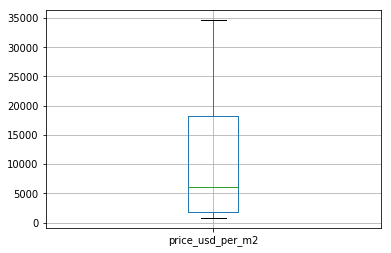

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
#Analizamos outliers. Ejemplo Boedo.
dfprop[dfprop['district_name'] == 'Boedo'].boxplot(column='price_usd_per_m2')

# Extracción de información sobre los ambientes
Usando RE para extraer información sobre los ambientes presente en el título y/o la descripción de la propiedad

In [48]:
import re
df_test_re = dfprop.head()
df_test_re[['description','title']]

,description,title
0,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB
2,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO
4,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...
5,MUY BUEN PH AL FRENTE CON ENTRADA INDEPENDIENT...,"MUY BUEN PH AL FRENTE DOS DORMITORIOS , PATIO,..."
6,EXCELENTE MONOAMBIENTE A ESTRENAR AMPLIO SUPER...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...


In [71]:
#z = re.match("(a\w+)\W(a\w+)", df_test_re['description'].iloc[0])
ambientes_title = []
for i in range(len(dfprop.index)):
    if re.search(r"\d\s"+'amb', str(dfprop['title'].iloc[i]), flags = re.IGNORECASE):
        ambientes_title.append(float(re.search(r"\d",re.search(r"\d\s"+'amb', dfprop['title'].iloc[i], flags = re.IGNORECASE).group()).group()))
    else:
        ambientes_title.append(np.nan)
dfprop['ambientes_title'] = ambientes_title
dfprop[['rooms','ambientes_title']].head()

,rooms,ambientes_title
0,2,2.0
2,2,2.0
4,2,2.0
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
9,NaN,NaN
11,2,2.0
12,1,NaN
13,1,NaN


In [75]:
ambientes_desc = []
for i in range(len(dfprop.index)):
    if re.search(r"\d\s"+'amb', str(dfprop['description'].iloc[i]), flags = re.IGNORECASE):
        ambientes_desc.append(float(re.search(r"\d",re.search(r"\d\s"+'amb', dfprop['description'].iloc[i], flags = re.IGNORECASE).group()).group()))
    else:
        ambientes_desc.append(np.nan)
dfprop['ambientes_desc'] = ambientes_desc


In [76]:
dfprop[['rooms','ambientes_title','ambientes_desc']].head(10)

,rooms,ambientes_title,ambientes_desc
0,2,2.0,2.0
2,2,2.0,2.0
4,2,2.0,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,NaN,NaN,NaN
9,NaN,NaN,NaN
11,2,2.0,2.0
12,1,NaN,3.0
13,1,NaN,NaN


Completamos los valores nulos en ROOM con los extraídos del título y la descripción:

In [78]:
dfprop.fillna({'rooms' : dfprop['ambientes_title']}, inplace = True)

In [79]:
dfprop.fillna({'rooms' : dfprop['ambientes_desc']}, inplace = True)

In [80]:
dfprop[['rooms','ambientes_title']].isna().sum()

rooms              29943
ambientes_title    63274
dtype: int64

In [56]:
dfprop.fillna({'ambientes_title' : dfprop['ambientes_desc']}, inplace = True)

Reemplazamos los valores en los que rooms no coincide con ambientes_title por este último.

In [86]:
dfprop.loc[dfprop['rooms'] != dfprop['ambientes_title'], 'rooms'] = dfprop.loc[dfprop['rooms'] != dfprop['ambientes_title'], 'ambientes_title']

In [90]:
#descartamos las columnas 'ambientes_title' y 'ambientes_desc' para evitar confusiones
dfprop = dfprop.drop(labels = ['ambientes_title', 'ambientes_desc'], axis = 1)

In [102]:
#Buscamos la descripción para extraer información sobre la cantidad de baños:
baños_desc = []
for i in range(len(dfprop.index)):
    if re.search(r"\d\s"+'baño', str(dfprop['description'].iloc[i]), flags = re.IGNORECASE):
        baños_desc.append(float(re.search(r"\d",re.search(r"\d\s"+'baño', dfprop['description'].iloc[i], flags = re.IGNORECASE).group()).group()))
    elif re.search(r"\d\s"+'bano', str(dfprop['description'].iloc[i]), flags = re.IGNORECASE):
        baños_desc.append(float(re.search(r"\d",re.search(r"\d\s"+'bano', dfprop['description'].iloc[i], flags = re.IGNORECASE).group()).group()))
    else:
        baños_desc.append(np.nan)
dfprop['baños_desc'] = baños_desc

In [107]:
#Buscamos el título para extraer información sobre la cantidad de baños:
baños_title = []
for i in range(len(dfprop.index)):
    if re.search(r"\d\s"+'baño', str(dfprop['title'].iloc[i]), flags = re.IGNORECASE):
        baños_title.append(float(re.search(r"\d",re.search(r"\d\s"+'baño', dfprop['title'].iloc[i], flags = re.IGNORECASE).group()).group()))
    elif re.search(r"\d\s"+'bano', str(dfprop['title'].iloc[i]), flags = re.IGNORECASE):
        baños_title.append(float(re.search(r"\d",re.search(r"\d\s"+'bano', dfprop['title'].iloc[i], flags = re.IGNORECASE).group()).group()))
    else:
        baños_title.append(np.nan)
#dfprop['baños_desc'] = baños_desc
np.sum(baños_title)

nan

In [104]:
dfprop['baños_desc'].sum()

14514.0

In [108]:
#dado que sólo hemos obtenido cantidad de baños para 14.5k registros,
#asumimos que si no dice nada al respecto, la propiedad tiene un baño.

dfprop.fillna({'baños_desc': 1}, inplace = True)
dfprop['baños_desc'].describe()

count    81503.000000
mean         1.082917
std          0.386448
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          9.000000
Name: baños_desc, dtype: float64

# Proceso de eliminacion de Outliers (en progreso)

paso uno, incluir quartil 1 y 3 (de price_usd_per_m2), en cada linea del DF original.
Luego, operar por linea, si el valor individual de la operacion se encuentra por debajo o por encima de las cotas. Las cotas quedan definidas:
Cota Minima: Q1 - 1.5*(Q3-Q1)
Cota Máxima: Q3 + 1.5*(Q3-Q1)
Luego se realiza un nueva visualizacion, observando la correccion en medias y desvios.
Con esto finalizado, se da paso al modulo de Buffer.

In [58]:
dfprop_group_quartiles=dfprop_group_nona[['25%','75%']]

In [59]:
dfprop_group_quartiles

25%  \
state_name                   district_name           city_name                                         
Bs.As. G.B.A. Zona Norte     Escobar                 Acacias Blancas                     1016.250000   
                                                     Altos de Matheu                      905.000000   
                                                     Barrio Acacias                      1519.876325   
                                                     Barrio Alamo Alto                   4000.000000   
                                                     Barrio Araucarias                   1686.665672   
                                                     Barrio Ceibos                       1662.240780   
                                                     Barrio Cerrado El Lucero            1129.158004   
                                                     Barrio Cerrado Fincas de Maschwitz  1325.000000   
                                                     Barrio Marinas                      1500.338983   
                                                     Barrio Parque Matheu                2392.905405   
                                                     Barrio Privado El Recodo  S.A.       872.860963   
                                                     Barrio Privado Villa Olivos         1252.604167   
                                                     Barrio San Matías                    792.444444   
                                                     Barrio Vistas                       1531.060606   
                                                     Belén de Escobar                     361.344180   
                                                     Campo Chico Country Club             867.857143   
                                                     Club de Campo Aranzazu               932.397004   
                                                     Country Club Aranjuez                485.714286   
                                                     Country Maschwitz Club               939.583333   
                                                     Country Maschwitz Privado            741.666667   
                                                     El Canton Barrio Puerto              261.808397   
                                                     El Cazador                            90.000000   
                                                     Fincas del Lago                     1342.021938   
                                                     Garín                                690.162239   
                                                     Haras Santa Maria                   1142.857143   
                                                     Loma Verde                           856.250000   
                                                     Los Angeles Village                 1065.989848   
                                                     Los Horneros CC                     1130.892256   
                                                     Los Robles de Maschwitz              976.040696   
                                                     Maquinista Savio                     590.575397   
...                                                                                              ...   
Buenos Aires Costa Atlántica Mar del Plata           Plaza Mitre                         1884.779262   
                                                     Plaza Rocha                         1034.851591   
                                                     Pompeya                              817.843866   
                                                     Punta Iglesia                       1604.651163   
                                                     Punta Mogotes                        488.888889   
                                                     Rumenco                             1525.000000   
                                         

In [96]:
dfprop.groupby(by = ['state_name','district_name', 'city_name', 'rooms'])[['surface_total_in_m2','price_usd_per_m2']].describe()

surface_total_in_m2  \
                                                                                                      count   
state_name               district_name           city_name                        rooms                       
Bs.As. G.B.A. Zona Norte Escobar                 Acacias Blancas                  4.0                   1.0   
                                                                                  7.0                   1.0   
                                                 Altos de Matheu                  4.0                   1.0   
                                                 Belén de Escobar                 4.0                   4.0   
                                                                                  1.0                   1.0   
                                                                                  2.0                  11.0   
                                                                                  3.0                   7.0   
                                                                                  5.0                   2.0   
                                                                                  6.0                   1.0   
                                                 Country Maschwitz Privado        5.0                   1.0   
                                                 El Cazador                       5.0                   1.0   
                                                 Fincas del Lago                  5.0                   1.0   
                                                 Garín                            3.0                   3.0   
                                                                                  5.0                   2.0   
                                                 Haras Santa Maria                4.0                   1.0   
                                                                                  5.0                   2.0   
                                                                                  6.0                   1.0   
                                                 Loma Verde                       7.0                   1.0   
                                                                                  5.0                   1.0   
                                                 Maschwitz                        4.0                   1.0   
                                                                                  3.0                   1.0   
                                                 Matheu                           4.0                   1.0   
                                                 Miraflores Country Club          4.0                   1.0   
                                                 Santa Isabel                     5.0                   1.0   
                                                 Septiembre                       4.0                   1.0   
                                                                                  6.0                   1.0   
                         General San Martín      Barrio Parque General San Martin 3.0                   6.0   
                                                 Billinghurst                     3.0                   3.0   
                                                                                  5.0                   2.0   
                                                 Jose Leon Suarez                 4.0                   1.0   
...                                                                                                     ...   
Buenos Aires Interior    General Pueyrredón      Sierra de los Padres             3.0                   2.0   
                         Lobos                   Lobos                            4.0                   2.0   
                                                                                  7.0       

# Predictivos - Drivers

A fines de no ampliar el codigo, comentamos el trabajo realizado.
COn la libreria WordCloud identificamos palabras que se repetian e indentificamos "terminso positivos", que pudieran explicar un incrmento del costo promedio.
Luego creamos variables dummies (0=no contiene 1=contiene), para plotear en forma boxplot el valor del m2 segun contiene o no la variable dummy.
No se observó relacion contundente.

# Predictivos - Buffers 

Imputacion de Price_USD_M2 con valor NaN

1- Asignar price por ubicacion geografica (buffer-reducido)

2- Asignar price por ubicacion geografica (buffer-ampliado)

3- Crear un cluster por country-state-district-city e imputar el precio por m2 promedio a los registros que no tengan Nan en city_name

4- Crear un cluster por country-state-district e imputar el precio por m2 promedio a los registros que tengan Nan en city_name y no tengan NaN en district_name

5- Eliminar registros que no se les haya podido imputar precio


In [60]:
# Cargo propiedades en el mapa usando lat lon
import geopandas
import shapely.wkt
import rtree
pd.options.display.max_rows = 10
import matplotlib.pyplot as plt
%matplotlib inline

from shapely.geometry import Point

# Funcion para crear puntos a partir del lat-lon
def from_x_y(df, x, y):
    gdf = geopandas.GeoDataFrame(df.drop([x, y], axis=1),
                                crs={'init': 'epsg:4326'},
                                geometry=[Point(xy) for xy in zip(df[x], df[y])])
    return gdf


def getProyectionBuffer(locations,buff):
    loc_gkba = locations.to_crs(crs = "+proj=tmerc +lat_0=-34.629269 +lon_0=-58.4633 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs")
    loc_gkba_buff=loc_gkba.copy()
    loc_gkba_buff.geometry = loc_gkba.buffer(buff)
    return loc_gkba_buff
    
# Funcion para obtener el precio promedio por buffer
def getMeanBuffer(dfprop_noprice_loc,location_price_gkba_buff,indexprop,variableToEstimate,buffer):
    
    locations_noprice=from_x_y(dfprop_noprice_loc.loc[[indexprop]], "lon", "lat")
    
     # Creo un buffer 
    locations_noprice_gkba_buff=getProyectionBuffer(locations_noprice,buffer)    
    
    # Borramos la columna 'price_aprox_usd' del dataframe que no tiene precio
    locations_noprice_gkba_buff.drop(variableToEstimate,axis=1,inplace=True)

    try:
        #Busco la interseccion
        intersection = geopandas.overlay(locations_noprice_gkba_buff,location_price_gkba_buff, how = "intersection")

        price_mean=intersection[variableToEstimate].mean()

        return float(price_mean)
    except:
        #Si no encuentro la interseccion, devuelvo 0
        return float(0)

    
def estimateVariable(dfToEstimate,variableToEstimate):

    # Obtengo dataframe de todas las propiedades de una localidad SIN precio
    dfprop_noprice=dfToEstimate.loc[((~dfToEstimate['lat'].isna()) &\
                               (~dfToEstimate['lon'].isna()) &\
                               dfToEstimate[variableToEstimate].isna() &\
                               (~dfToEstimate['district_name'].isna()))]

    # Obtengo dataframe de todas las propiedades de una localidad CON precio
    dfprop_price=dfToEstimate.loc[((~dfToEstimate['lat'].isna()) &\
                             (~dfToEstimate['lon'].isna()) &\
                             (~dfToEstimate[variableToEstimate].isna())&\
                             (~dfToEstimate['district_name'].isna()))]


    # Creo key de listado de localidades
    dfprop_noprice['district_name_key']=dfprop_noprice['country_name']+"-"+\
                                      dfprop_noprice['state_name']+"-"+\
                                      dfprop_noprice['district_name']


    dfprop_price['district_name_key']=dfprop_price['country_name']+"-"+\
                                      dfprop_price['state_name']+"-"+\
                                      dfprop_price['district_name']

    crs = {'init': 'epsg:4326'} 

    # Filtro por una localidad
    # Repito la operacion por localidad 
    for proploc in dfprop_noprice['district_name_key'].unique():
        i=1

        # Extraigo en 2 dataframes las propiedades sin precio y con precio
        dfprop_noprice_loc= dfprop_noprice.loc[dfprop_noprice['district_name_key']==proploc]
        dfprop_price_loc= dfprop_price.loc[dfprop_price['district_name_key']==proploc]

        # Cargo todas las propiedades con precio en geopandas
        locations_with_price = from_x_y(dfprop_price_loc.loc[:,[variableToEstimate,'lon','lat']], "lon", "lat")

        # Creo la proyeccion de las propiedades con precio 
        locations_with_price_gkba_buff=getProyectionBuffer(locations_with_price,1) 
        
        print('Localidad: '+proploc + 'Cantidad de propiedades:'+ str(dfprop_noprice_loc['operation'].count()))
        # Busco el precio para cada propiedad de esa localidad 
        for iprop in dfprop_noprice_loc[:].index:
            
            #print('\tBusco precio por 1Km')
            # Busco y asigno el precio promedio de las propiedades a 1km de distancia 
            mean_price=getMeanBuffer(dfprop_noprice_loc,locations_with_price_gkba_buff,iprop,variableToEstimate,1000)

            # Si no encuentro un precio promedio de las propiedades a 1.5km de distancia 
            if(mean_price==0):
                #print('\tBusco precio por 1.5Km')
                mean_price=getMeanBuffer(dfprop_noprice_loc,locations_with_price_gkba_buff,iprop,variableToEstimate,1500)


            city_name=str(dfprop_noprice_loc.loc[:,'city_name'].loc[iprop])
            # Si no encuentro un precio promedio y la propiedad tiene barrio, busco el promedio para el barrio  
            if((mean_price==0) & (city_name!='nan')):
                #print('\tCalculo por barrio',city_name)
                # Creo mascara para solo calcular la media de las propiedades con precio en el mismo barrio
                city_name_mask=(dfprop_price_loc.loc[:,'city_name']==city_name)
                #VArifico que haya alguna propiedad con precio para ese barrio
                if(dfprop_price_loc[city_name_mask].empty==False):
                    # Aplico la mascara y calculo la media
                    #print('calculo media por barrio')
                    mean_price=dfprop_price_loc.loc[city_name_mask,variableToEstimate].median()
                else:
                    mean_price=0

             # Si no encuentro un precio promedio busco el promedio para la localidad  
            if(mean_price==0):
                #Calculo el precio promedio en base a propiedades en la misma localidad
               # print('\tCalculo por localidad')
                mean_price=dfprop_price_loc[variableToEstimate].median()

            print('\t'+str(i)+' - Mean Price= '+str(mean_price))

            dfToEstimate.loc[dfToEstimate.loc[[iprop]].index,variableToEstimate]=mean_price
            i=i+1
            
        print('---------------------------------------------') 
        
    return dfToEstimate
       


#dfprop=estimateVariable(dfprop,'price_usd_per_m2')


ModuleNotFoundError: No module named 'rtree'

Imputamos el valor de 'price_usd_per_m2' promedio del distrito en los casos cuyo valor es 'Nan' y no tienen lat-lon

In [ ]:
# Generamos una key de zona
dfprop['district_name_key']=dfprop['country_name']+"-"+\
                            dfprop['state_name']+"-"+\
                            dfprop['district_name']

# Creamos un dataframe auxiliar
dfprop_price=dfprop


# Agrupamos por key y sacamos precio promedio
dfprop_price=dfprop_price.groupby('district_name_key')[['price_usd_per_m2']].mean()


# Renombro columnas a efectos practicos en la interpretacion
dfprop_price.rename(columns={'price_usd_per_m2':'price_usd_per_m2_district'},inplace=True)


#Unimos las tablas por left para agregar la columna precio por distrito
dfprop=pd.merge(dfprop,dfprop_price,how='left',on='district_name_key')

#Imputamos el precio promedio por district a los casos que tengan Nan y que tengan District
dfprop.loc[(dfprop['price_usd_per_m2'].isna() &\
          (~dfprop['district_name'].isna())),'price_usd_per_m2']=dfprop['price_usd_per_m2_district']


# Elimino las columnas utilizadas en este analisis
dfprop.drop(['price_usd_per_m2_district','district_name_key'],axis=1,inplace=True)

dfprop.shape

Eliminamos las propiedades a las cuales no se les pudo imputar un valor en 'price_usd_per_m2'


In [ ]:
dfprop=dfprop.loc[(~dfprop['price_usd_per_m2'].isna())]

Imputamos el precio en base a 'price_usd_per_m2' y 'surface_total_in_m2'

In [ ]:
#Asignamos la moneda USD 
dfprop.loc[dfprop['price'].isna() &\
           (~dfprop['price_usd_per_m2'].isna())&\
            (~dfprop['surface_total_in_m2'].isna()),\
           'currency']= 'USD'

#Calculamos el precio en dolares para las propiedades que tenemos la superficie total y el valor en USD por m2 
dfprop.loc[dfprop['price'].isna() &\
           (~dfprop['price_usd_per_m2'].isna())&\
            (~dfprop['surface_total_in_m2'].isna()),\
           'price']= dfprop['price_usd_per_m2']*dfprop['surface_total_in_m2']

dfprop.loc[dfprop['price_aprox_usd'].isna() &\
           (~dfprop['price_usd_per_m2'].isna())&\
            (~dfprop['surface_total_in_m2'].isna()),\
           'price_aprox_usd']= dfprop['price_usd_per_m2']*dfprop['surface_total_in_m2']

In [ ]:
# Cantidad de registros sin precio m2 cuadrado ni precio 
dfpropa=dfprop.loc[:,\
            ['price','price_aprox_usd','currency','surface_total_in_m2','surface_covered_in_m2','price_per_m2','price_usd_per_m2']]

dfpropa[dfpropa.isnull().any(axis=1)].isna().sum()